In [1]:

%matplotlib inline

In [28]:
# %%writefile Binaural_cues.py
import scipy.signal as dsp
import gammatone.filters as gt_filters
import soundfile as sf
from apgf import APGF
import numpy as np
#import APGF
# from ipywidgets import FloatProgress
# from IPython.display import display

# matplotlib.use('TkAgg')

def Efficient_ccf(x1,x2):
    """calculate cross-crrelation function in frequency domain, which is more 
    efficient than the direct calculation"""
    
    if x1.shape[0] != x2.shape[0]:
        raise Exception('length mismatch')
    wav_len = x1.shape[0]
    # hanning window before fft
    wf = np.hanning(wav_len)
    x1 = x1*wf
    x2 = x2*wf

    X1 = np.fft.fft(x1,2*wav_len-1)# equivalent to add zeros 
    X2 = np.fft.fft(x2,2*wav_len-1)
    ccf_unshift = np.real(np.fft.ifft(np.multiply(X1,np.conjugate(X2))))
    ccf = np.concatenate([ccf_unshift[wav_len:],ccf_unshift[:wav_len]],axis=0)
    
    return ccf
    
    
def get_ITD(x,fs,max_delay=None,inter_method='parabolic'):
    """
    estimate ITD based on interaural corss-correlation function
    itd = chann0_delay - chann1_delay
    x_detrend[:, 0]: left ear signal, x_trend[:, 1]: right ear signal
    corr(i) = sum(x0[t]*x1[t-i])
        | >0 chann0 lead
    itd |
        | <0 chann1 lead
    input: 
        max_delay: maximum value of ITD, which equals sampling rate * maximum delay(s), default value: 1ms
        inter_method: method of ccf interpolation, "None"(default),"parabolic","exponential".
    """
    wav_len = x.shape[0]
    
    # detrend
    # x_detrend = x-np.mean(x,axis=0)
    x_detrend = x
    
    if max_delay == None:
        max_delay = int(1e-3*fs)# default 1ms, if sampling rate = 16000Hz, the number of sampling points is 16.
    
    if False:
        # time domain
        ccf_full = np.correlate(x_detrend[:,0],x_detrend[:,1],mode='full')
        ccf = ccf_full[wav_len-1-max_delay:wav_len+max_delay]
    else:
        # frequency domain
        ccf_full = Efficient_ccf(x_detrend[:,0],x_detrend[:,1])
        ccf = ccf_full[wav_len-1-max_delay:wav_len+max_delay]
    
    ccf_std = ccf/(np.sqrt(np.sum(x_detrend[:,0]**2)*np.sum(x_detrend[:,1]**2)))
    max_pos = np.argmax(ccf)  # Optimal delay in signal alignment between the left and right ears
    
    ######################
    if False:
        plt.figure(1)
        plt.clf()
        plt.subplot(311);    plt.plot(ccf_std);
        plt.plot([wav_len-max_delay-1,wav_len-max_delay-1],[0,1],'r')
        plt.plot([wav_len+max_delay-1,wav_len+max_delay-1],[0,1],'r')
        plt.plot(wav_len-1-max_delay+max_pos,ccf_std[wav_len-1-max_delay+max_pos],'x',linewidth=2)

        plt.subplot(312);    plt.plot(x[:,0])
        plt.subplot(313);    plt.plot(x[:,1])

        plt.show(block=False)
        plt.pause(0.001)
    ######################
    
    # exponential interpolation 
    delta = 0
    if inter_method == 'exponential':
        if max_pos> 0 and max_pos < max_delay*2-2:
            if np.min(ccf[max_pos-1:max_pos+2]) > 0:
                delta = (np.log(ccf[max_pos+1])-np.log(ccf[max_pos-1]))/\
                            (4*np.log(ccf[max_pos])-
                             2*np.log(ccf[max_pos-1])-
                             2*np.log(ccf[max_pos+1]))
    elif inter_method == 'parabolic':
        if max_pos> 0 and max_pos < max_delay*2-2:
            delta = (ccf[max_pos-1]-ccf[max_pos+1])/(2*(ccf[max_pos+1]-2*ccf[max_pos]+ccf[max_pos-1]))
        
    ITD = float((max_pos-max_delay-1+delta))/fs*1e3

    return [ITD,ccf_std] # ITD(ms)



def get_ILD(x):
    """ ILD
    To be consistent with ITD:
    ild = 10log10(chann1_energy/chann0_energy)
        |>0 chann1 lead
    ild |
        |<0 chann0 lead
    """
    if np.sum(x[:,1]**2) == 0:
    #         plt.plot(x)
        print ('right channel no signal')
        return np.inf
    if np.sum(x[:,1]**2) == 0:
        print('left channel no signal')
    
    return 10*np.log10(np.sum(x[:,1]**2)/np.sum(x[:,0]**2)+1e-10)

def Haircell_model(x,fs,ihc_type='Lindemann'):
    """minic the transduction of inner hair cell, in other words, extract the envelope of inputsignal
  
    Args:
        x: input signal
        ihc_type: different model used in previous work
            Lindemann: half-wave rectify + low-pass filter(1th Butterworth, cutoff-frequency 800Hz)
            Breebart: half-wave rectify + low-pass filter(5th, cutoff-frequency 770Hz)
            More to added....
            
    Returns:
        the envelope of input x
        
    """
    if ihc_type== 'Lindemann':
        x_rectify = np.maximum(x,0) # half wav rectification
        # low-pass filter
        b,a = dsp.butter(1,800.0/(fs/2.0))
        env = dsp.filtfilt(b,a,x_rectify,axis=1)
    elif ihc_type == 'Breebaart':
        x_rectify = np.maximum(x,0)
        # low pass filter
        b,a = dsp.butter(5,2000.0/(fs/2.0))
        env = x_rectify
        for i in range(5):
            env = dsp.filtfilt(b,a,env,axis=1)
    elif ihc_type == 'Roman':
        x_rectify = np.maximum(x,0)
        env = np.sqrt(x_rectify)
    elif ihc_type == 'rectify':
        env = np.maximum(x,0)
    else:
        raise Exception('unknown model type')
    
    return env
        
    
def GetERB(cf):
    """calculate the ERB(Hz) of given center frequency
    cf: center frequency in kHz
    """
    return 24.7*(4.37*cf/1000+1.0)


def GF_spectrogram(wav,fs,cfs):
    """auditory peripheral model, which consists of Gammatone filterbank, half-wave rectifier,
    and low-pass filter
    
    Args:
        wav: wave form, length(in sameple)*chanel_num
        fs:
        
    Returns:
        spectralgram, size: freq_channel_num*channel_num*sampel_num
    
    """
    coefs = gt_filters.make_erb_filters(fs=fs,centre_freqs=cfs)    
    left_audiogram = gt_filters.erb_filterbank(wav[:,0],coefs)
    right_audiogram = gt_filters.erb_filterbank(wav[:,1],coefs)
    
    lr_audiogram = np.concatenate((left_audiogram[:,:,np.newaxis],
                                   right_audiogram[:,:,np.newaxis]),axis=2)
    
    return lr_audiogram


def APGF_spectrogram(wav, fs, cfs):
    """
    用 APGF 模块计算 cochleagram
    :param wav: 输入的音频信号 (length, channel)
    :param fs: 采样率
    :param cfs: 中心频率列表
    :return: cochleagram
    """
    num_channels = len(cfs)
    apgf = APGF(sample_rate=fs, low_frequency=cfs[0], high_frequency=cfs[-1], channel_count=num_channels)

    left_audiogram = apgf.process(wav[:, 0])  # 处理左耳信号
    right_audiogram = apgf.process(wav[:, 1])  # 处理右耳信号

    # 将左右耳信号结合
    lr_audiogram = np.stack([left_audiogram, right_audiogram], axis=2)
    return lr_audiogram

def butter_spectrogram(wav,fs,cfs):
    """
    
    """
    wav_std = wav
    wav_len = wav.shape[0]
    
    # auditory filter 
    filter_num = cfs.shape[0]
    audiogram = np.zeros((filter_num,wav_len,2))
    cutoff = np.zeros(2)
    for filter_i in range(filter_num):
        erb = GetERB(cfs[filter_i])
        cutoff[0] = cfs[filter_i]-erb/2
        cutoff[1] = cfs[filter_i]+erb/2
        sos = dsp.butter(Wn=cutoff/fs*2,btype='bandpass',N=6,output='sos')
        audiogram[filter_i,:,:] = dsp.sosfiltfilt(x=wav_std,sos=sos,axis=0)
    
    return audiogram


def Auditory_peripheral(wav,fs,cfs,filter_type,ihc_type=None):
    """ihc_type: different model used in previous work
            Lindemann: half-wave rectify + low-pass filter(1th Butterworth, cutoff-frequency 800Hz)
            Breebart: half-wave rectify + low-pass filter(5th, cutoff-frequency 770Hz)
            More to added.... 
    """
    if len(cfs.shape) == 0:
        cfs = np.reshape(cfs,newshape=[1])
        
    freq_chann_num = cfs.shape[0]

    if filter_type=='Gammatone':
        audiogram = GF_spectrogram(wav,fs,cfs)
    elif filter_type == 'Gammatone_AP':
        audiogram = APGF_spectrogram(wav,fs,cfs)
    elif filter_type == 'Butterworth':
        audiogram = butter_spectrogram(wav,fs,cfs)
    else:
        raise Exception('unsupported filter type')
    
    if audiogram.shape[0] != freq_chann_num:
        raise Exception('wrong shape of audiogram')
    
    if ihc_type == None:
        env = audiogram
    else:
#         print 'ihc model: %s'%ihc_type
        env = Haircell_model(audiogram,fs,ihc_type)
    
    return [audiogram,env]


def GetCues(tar,interfer,fs,frame_len,filter_type,cfs,frame_shift=None,max_delay=None,ihc_type=None):
    """calculate binaural localization cues, [itds,ilds,ccfs]
    
    Args:
        tar: target signal
        fs: sample frequency
        frame_len: 
        filter_type: "Gammatone" / "Butterworth"
        cfs: center frequencies of filters
        frame_shift: default frame_len/2
        max_daly: the maximum delay(sample), default frame_len-1
        ihc_type: different model used in previous work
            Lindemann: half-wave rectify + low-pass filter(1th Butterworth, cutoff-frequency 800Hz)
            Breebart: half-wave rectify + low-pass filter(5th, cutoff-frequency 770Hz)
            More to added.... 
    Returns:
        [[itds,ilds],ccfs]
    """
    
    wav_len = tar.shape[0]
    if wav_len != interfer.shape[0]:
        raise Exception('length do match')
    
    if frame_shift == None: # default overlap: frame_len/2
        frame_shift = int(frame_len/2)
    
    freq_chann_num = cfs.shape[0]
    
    tar_audiogram,_ = Auditory_peripheral(tar,fs,cfs,filter_type,ihc_type)
    interfer_audiogram = Auditory_peripheral(interfer,fs,cfs,filter_type,ihc_type)
    
    mix_audiogram = tar_audiogram + interfer_audiogram
    
    if ihc_type == None:
        mix_env = mix_audiogram
    else:
        print('ihc model: %s'%ihc_type)
        mix_env = Haircell_model(mix_audiogram,fs,ihc_type)
    

    frame_num = int((wav_len-frame_len-frame_len)/frame_shift+1)    
    if max_delay == None:
        max_delay = frame_len-1

    spatial_cues = np.zeros((freq_chann_num,frame_num,2),dtype=np.float32) # [itd_frame,ild_frame]
    ccf_std_all = np.zeros((freq_chann_num,frame_num,max_delay*2+1),dtype=np.float32)
    SNR_all = np.zeros((freq_chann_num,frame_num),dtype=np.float32)
    
    for freq_chann_i in range(freq_chann_num):
        itds_chann = []
        ilds_chann = []
        ccfs_chann = []
        # print(cfs[freq_chann_i])
        for frame_i in range(frame_num):
            frame_start_pos = frame_i*frame_shift+frame_len
            frame_end_pos = frame_start_pos+frame_len
        
            mix_env_chann_fram = mix_env[freq_chann_i,frame_start_pos:frame_end_pos]
            
            tar_chann_frame = tar_audiogram[freq_chann_i,frame_start_pos:frame_end_pos]
            interfer_chann_frame = interfer_audiogram[freq_chann_i,frame_start_pos:frame_end_pos]
            SNR_chan_frame = 10*np.log10(np.sum(tar_chann_frame**2)/np.sum(interfer_chann_frame**2))
            
            # bianural cues
            itd_frame,ccf_std_frame = get_ITD(mix_env_chann_fram,fs,max_delay=max_delay)
            ild_frame = get_ILD(mix_env_chann_fram)
            # check whether ILD is valid
            if ild_frame == np.inf:
                print(freq_channel_i,frame_i)
                raise Exception('invalid ild')
                
            spatial_cues[freq_chann_i,frame_i,0]=itd_frame
            spatial_cues[freq_chann_i,frame_i,1]=ild_frame
            ccf_std_all[freq_chann_i,frame_i,:] = ccf_std_frame
            SNR_all[freq_chann_i,frame_i] = SNR_chan_frame
            
    return [spatial_cues,ccf_std_all,SNR_all]


def ProcessBar(max_count=100):
    f = FloatProgress(min=0, max=max_count) # instantiate the bar
    display(f) # display the bar
    return f


def GetCues_clean(tar,fs,frame_len,filter_type,cfs,frame_shift=None,max_delay=None,ihc_type=None):
    """calculate binaural localization cues, [itds,ilds,ccfs]
    
    Args:
        tar: target signal
        fs: sample frequency
        frame_len: 
        filter_type: "Gammatone" / "Butterworth"
        cfs: center frequencies of filters
        frame_shift: default frame_len/2
        max_daly: the maximum delay(sample), default frame_len-1
        ihc_type: different model used in previous work
            Lindemann: half-wave rectify + low-pass filter(1th Butterworth, cutoff-frequency 800Hz)
            Breebart: half-wave rectify + low-pass filter(5th, cutoff-frequency 770Hz)
            More to added.... 
    Returns:
        [[itds,ilds],ccfs]
    """
    
    wav_len = tar.shape[0]
    
    if frame_shift == None: # default overlap: frame_len/2
        frame_shift = int(frame_len/2)
    
    freq_chann_num = cfs.shape[0]
    
    _,tar_env = Auditory_peripheral(tar,fs,cfs,filter_type,ihc_type)

    frame_num = int((wav_len-frame_len-frame_len)/frame_shift+1)
    spatial_cues = np.zeros((freq_chann_num,frame_num,2),dtype=np.float32) # [itd_frame,ild_frame]
    
    if max_delay == None:
        max_delay = frame_len-1
        
    ccf_std_all = np.zeros((freq_chann_num,frame_num,max_delay*2+1),dtype=np.float32)
    
    for freq_chann_i in range(freq_chann_num):
        itds_chann = []
        ilds_chann = []
        ccfs_chann = []
        # print(cfs[freq_chann_i])
        for frame_i in range(frame_num):
            frame_start_pos = frame_i*frame_shift+frame_len
            frame_end_pos = frame_start_pos+frame_len
            
            tar_chann_frame = tar_env[freq_chann_i,frame_start_pos:frame_end_pos,:]
            
            ##################
#             pdb.set_trace()
            # raw_input('pause: ')
            ##################
            
            # bianural cues
            
            itd_frame,ccf_std_frame = get_ITD(tar_chann_frame,fs,max_delay=max_delay)
            ild_frame = get_ILD(tar_chann_frame)
            # check whether ILD is valid
            if ild_frame == np.inf:
                print(freq_channel_i,frame_i)
                raise Exception('invalid ild')
                
            spatial_cues[freq_chann_i,frame_i,0]=itd_frame
            spatial_cues[freq_chann_i,frame_i,1]=ild_frame
            ccf_std_all[freq_chann_i,frame_i,:] = ccf_std_frame
            
    return [spatial_cues,ccf_std_all]

In [29]:
import matplotlib.pyplot as plt
%matplotlib inline

In [36]:
tar,fs = sf.read('out.wav')

In [37]:
tar = dsp.resample(tar, int(tar.shape[0]/48000*16000))

In [38]:
cfs = gt_filters.centre_freqs(cutoff=80,fs=16000,num_freqs=30)

In [39]:
cues_butter,ccf = GetCues_clean(cfs=cfs[-2:],
                           filter_type='Butterworth',
                           frame_len=int(fs*0.023),
                           frame_shift=int(fs*0.023*0.5),
                           tar=tar,fs=fs,
                           max_delay=int(fs*0.001),
                           ihc_type='Breebaart')

In [40]:
cues_gamma,ccf = GetCues_clean(cfs=cfs[-2:],
                           filter_type='Gammatone',
                           frame_len=int(fs*0.023),
                           frame_shift=int(fs*0.023*0.5),
                           tar=tar,fs=fs,
                           max_delay=int(fs*0.001),
                           ihc_type='Breebaart')

In [41]:
cues_gamma_ap,ccf = GetCues_clean(cfs=cfs[-2:],
                           filter_type='Gammatone_AP',
                           frame_len=int(fs*0.023),
                           frame_shift=int(fs*0.023*0.5),
                           tar=tar,fs=fs,
                           max_delay=int(fs*0.001),
                           ihc_type='Breebaart')

ITD

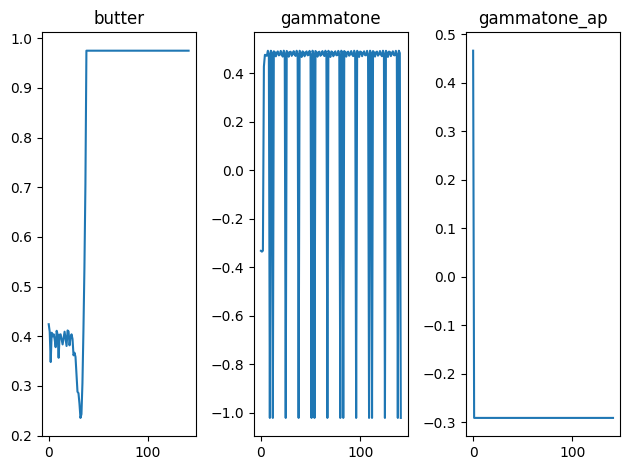

In [10]:
plt.subplot(131); plt.plot(cues_butter[-1,:,0]); plt.title('butter')
plt.subplot(132); plt.plot(cues_gamma[-1,:,0]); plt.title('gammatone')
plt.subplot(133); plt.plot(cues_gamma_ap[-1,:,0]); plt.title('gammatone_ap')
plt.tight_layout()

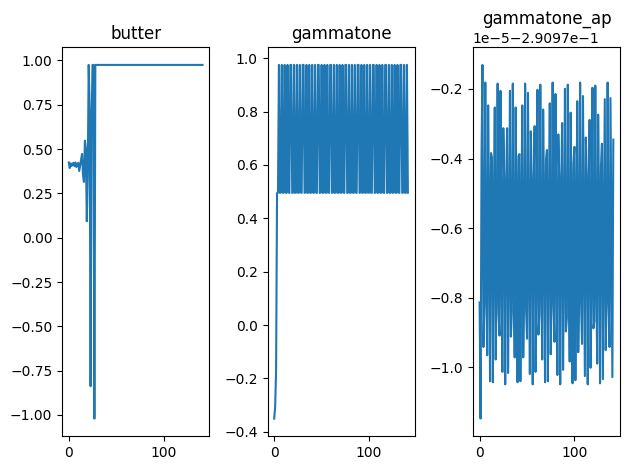

In [11]:
plt.subplot(131); plt.plot(cues_butter[0,:,0]); plt.title('butter')
plt.subplot(132); plt.plot(cues_gamma[0,:,0]); plt.title('gammatone')
plt.subplot(133); plt.plot(cues_gamma_ap[0,:,0]); plt.title('gammatone_ap')
plt.tight_layout()

ILD

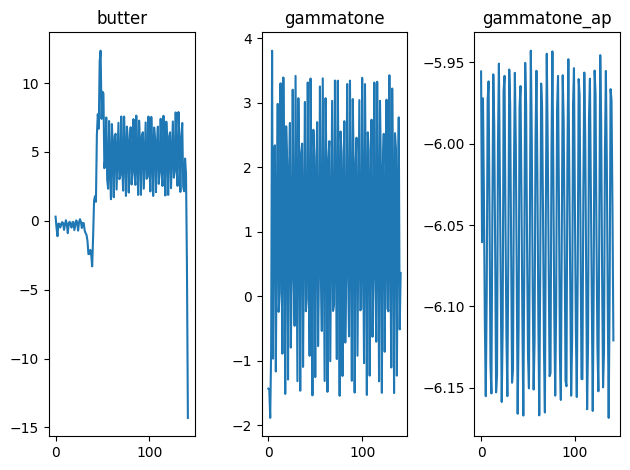

In [12]:
plt.subplot(131); plt.plot(cues_butter[-1,:,1]); plt.title('butter')
plt.subplot(132); plt.plot(cues_gamma[-1,:,1]); plt.title('gammatone')
plt.subplot(133); plt.plot(cues_gamma_ap[-1,:,1]); plt.title('gammatone_ap')
plt.tight_layout()

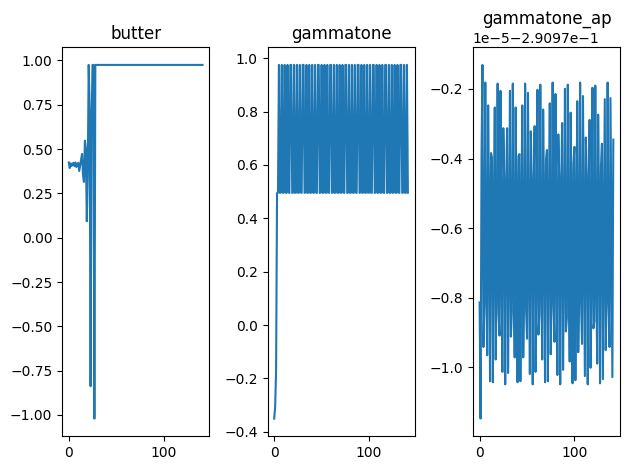

In [13]:
plt.subplot(131); plt.plot(cues_butter[0,:,0]); plt.title('butter')
plt.subplot(132); plt.plot(cues_gamma[0,:,0]); plt.title('gammatone')
plt.subplot(133); plt.plot(cues_gamma_ap[0,:,0]); plt.title('gammatone_ap')
plt.tight_layout()

In [14]:
import numpy as np
from scipy.io import wavfile
# Define parameters
#fs = 16000
fs, signal = wavfile.read("out.wav")
frame_len = int(fs * 0.023)  # frame length 23ms
frame_shift = int(fs * 0.023)  # 23ms
cfs = np.linspace(50, 3500, 32)  # centre frequencies, 32 frequency bands
filter_type = "Gammatone_AP"  # filter type
ihc_type = "Breebaart"  # Iner 内耳模型类型

# # 假设有左耳和右耳目标信号 tar
# tar = np.random.randn(fs * 1, 2)  # 模拟 1 秒双通道音频信号（tar[:,0]=左，tar[:,1]=右）



if signal.ndim != 2 or signal.shape[1] != 2:
    raise ValueError("The audio file must be a stereo (2-channel) signal.")

left_channel = signal[:, 0]
right_channel = signal[:, 1]

# 提取 ITD 和 ILD
spatial_cues, ccf = GetCues_clean(
    tar=signal,
    fs=fs,
    frame_len=frame_len,
    filter_type=filter_type,
    cfs=cfs,
    frame_shift=frame_shift,
    ihc_type=ihc_type,
)

# Separate ITD and ILD
ITD = spatial_cues[..., 0]  # ITD(ms)
ILD = spatial_cues[..., 1]  # ILD(dB)

np.save("itd.npy", ITD)
np.save("ild.npy", ILD)

print("ITD shape:", ITD.shape)  # (Number of frequency channels, number of frames)
print("ILD shape:", ILD.shape)
print("ITD stats: mean =", np.mean(ITD), "std =", np.std(ITD))
print("ILD stats: mean =", np.mean(ILD), "std =", np.std(ILD))

ITD shape: (32, 216)
ILD shape: (32, 216)
ITD stats: mean = -0.44093412 std = 1.5133891e-05
ILD stats: mean = -4.3446383 std = 0.09230116


In [51]:
cfs

array([  50.        ,  161.29032258,  272.58064516,  383.87096774,
        495.16129032,  606.4516129 ,  717.74193548,  829.03225806,
        940.32258065, 1051.61290323, 1162.90322581, 1274.19354839,
       1385.48387097, 1496.77419355, 1608.06451613, 1719.35483871,
       1830.64516129, 1941.93548387, 2053.22580645, 2164.51612903,
       2275.80645161, 2387.09677419, 2498.38709677, 2609.67741935,
       2720.96774194, 2832.25806452, 2943.5483871 , 3054.83870968,
       3166.12903226, 3277.41935484, 3388.70967742, 3500.        ])

In [58]:
cfs[24]

np.float64(2720.967741935484)

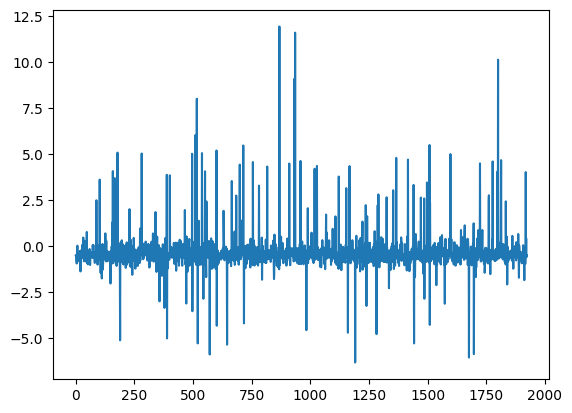

In [65]:
plt.plot(ITD[3,:]);